In [3]:
print("--- Step 1: Importing Libraries ---")
import os
import shutil
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

--- Step 1: Importing Libraries ---


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

In [5]:
print("\n--- Step 2A: Setting Configuration ---")

# Paths for your local machine
train_dir = 'C:/Users/Raj/Downloads/archive/deepfake_database/train'
test_dir = 'C:/Users/Raj/Downloads/archive/deepfake_database/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224 
BATCH_SIZE = 32
N_CLASSES = 2
routings = 3
dim_capsule = 16

# ==============================================================================
# CELL 2B: COPY PERSONAL PHOTOS (NEW CELL)
# ==============================================================================
print("\n--- Step 2B: Copying Personal Photos ---")

personal_photos_dir = 'C:/Users/Raj/Downloads/archive/deepfake_database/my_real_photos'
destination_dir = 'C:/Users/Raj/Downloads/archive/deepfake_database/my_real_photos/real'

# Check if the personal photos directory exists
if os.path.exists(personal_photos_dir) and os.path.isdir(personal_photos_dir):
    files_to_copy = [f for f in os.listdir(personal_photos_dir) if os.path.isfile(os.path.join(personal_photos_dir, f))]
    
    if files_to_copy:
        print(f"Found {len(files_to_copy)} personal photos. Copying to training set...")
        for filename in files_to_copy:
            source_path = os.path.join(personal_photos_dir, filename)
            destination_path = os.path.join(destination_dir, filename)
            shutil.copy2(source_path, destination_path)
        print("✅ Successfully copied personal photos.")
    else:
        print("Personal photos folder is empty. Skipping copy.")
else:
    print(f"Personal photos directory not found at '{personal_photos_dir}'.")
    print("Skipping copy step. Create the folder and add images to use this feature.")



--- Step 2A: Setting Configuration ---

--- Step 2B: Copying Personal Photos ---
Personal photos folder is empty. Skipping copy.


In [6]:
print("\n--- Step 3: Preparing Data Generators ---")
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



--- Step 3: Preparing Data Generators ---
Found 9619 images belonging to 2 classes.
Found 2404 images belonging to 2 classes.
Found 330 images belonging to 2 classes.


In [8]:
print("\n--- Step 4: Building the Hybrid Model ---")

def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
    def build(self, input_shape):
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule, self.dim_capsule, self.input_dim_capsule], initializer='glorot_uniform', name='W')
        self.built = True
    def call(self, inputs, training=None):
        u_hat = tf.einsum('ijkm,bjm->bijk', self.W, inputs)
        b = tf.zeros(shape=[tf.shape(u_hat)[0], self.num_capsule, self.input_num_capsule])
        outputs = None
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s = tf.einsum('bij,bijk->bik', c, u_hat)
            outputs = squash(s)
            if i < self.routings - 1:
                agreement = tf.einsum('bik,bijk->bij', outputs, u_hat)
                b += agreement
        return outputs
    def get_config(self):
        config = super().get_config()
        config.update({"num_capsule": self.num_capsule, "dim_capsule": self.dim_capsule, "routings": self.routings})
        return config

base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
features = base_model(inputs, training=False)
primarycaps_conv = layers.Conv2D(filters=dim_capsule * 32, kernel_size=3, strides=2, padding='valid', activation='relu')(features)
primarycaps_reshaped = layers.Reshape((-1, dim_capsule))(primarycaps_conv)
primarycaps_squashed = layers.Lambda(squash, name='primarycaps_squash')(primarycaps_reshaped)
digitcaps = CapsuleLayer(num_capsule=N_CLASSES, dim_capsule=dim_capsule, routings=routings, name='digitcaps')(primarycaps_squashed)

def compute_capsule_length(x):
    return K.sqrt(K.sum(K.square(x), -1))
out_caps = layers.Lambda(compute_capsule_length, name='final_output')(digitcaps)

model = models.Model(inputs, out_caps)


--- Step 4: Building the Hybrid Model ---


In [7]:
print("\n--- Step 5A: Initial Training ---")
def margin_loss(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
    return K.mean(K.sum(L, 1))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=margin_loss, metrics=['accuracy'])
model.summary()

history = model.fit(
    train_generator,
    epochs=10, 
    validation_data=validation_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# ==============================================================================
# CELL 5B: FINE-TUNING (UNFREEZE AND TRAIN SLOWLY)
# ==============================================================================
print("\n--- Step 5B: Fine-Tuning ---")
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss=margin_loss, metrics=['accuracy'])
model.summary()

fine_tune_epochs = 15
initial_epochs = len(history.history['loss'])
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=validation_generator,
    callbacks=[
        ModelCheckpoint('best_hybrid_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
    ]
)

print("\n✅ Training complete! The best model has been saved as 'best_hybrid_model.h5'.")



--- Step 5A: Initial Training ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 3, 3, 512)           │       5,898,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 288, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ primarycaps_squash (Lambda)          │ (None, 288, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ digitcaps (CapsuleLayer)             │ (None, 2, 16)               │         147,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_output (Lambda)                │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,304,192 (31.68 MB)

 Trainable params: 6,046,208 (23.06 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

C:\Users\Raj\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - accuracy: 0.7527 - loss: 0.1556 - val_accuracy: 0.6186 - val_loss: 0.2330
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.9017 - loss: 0.0705 - val_accuracy: 0.5819 - val_loss: 0.2492
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 1150s 4s/step - accuracy: 0.9294 - loss: 0.0534 - val_accuracy: 0.6493 - val_loss: 0.2312
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accuracy: 0.9424 - loss: 0.0473 - val_accuracy: 0.6069 - val_loss: 0.2723
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.9433 - loss: 0.0441 - val_accuracy: 0.6597 - val_loss: 0.2021
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9560 - loss: 0.0377 - val_accuracy: 0.6431 - val_loss: 0.2639
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.9574 - loss: 0.0353 - val_accuracy: 0.6032 - val_loss: 0.2790
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - accuracy: 0.9621 - loss: 0.0350 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 3, 3, 512)           │       5,898,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 288, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ primarycaps_squash (Lambda)          │ (None, 288, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ digitcaps (CapsuleLayer)             │ (None, 2, 16)               │         147,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_output (Lambda)                │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,304,192 (31.68 MB)

 Trainable params: 7,907,648 (30.17 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 9/23
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8386 - loss: 0.1043

301/301 ━━━━━━━━━━━━━━━━━━━━ 648s 2s/step - accuracy: 0.8387 - loss: 0.1042 - val_accuracy: 0.6173 - val_loss: 0.2490 - learning_rate: 1.0000e-05
Epoch 10/23
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9171 - loss: 0.0576

301/301 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - accuracy: 0.9171 - loss: 0.0576 - val_accuracy: 0.6893 - val_loss: 0.2039 - learning_rate: 1.0000e-05
Epoch 11/23
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9418 - loss: 0.0432

301/301 ━━━━━━━━━━━━━━━━━━━━ 644s 2s/step - accuracy: 0.9418 - loss: 0.0432 - val_accuracy: 0.7313 - val_loss: 0.1761 - learning_rate: 1.0000e-05
Epoch 12/23
301/301 ━━━━━━━━━━━━━━━━━━━━ 610s 2s/step - accuracy: 0.9486 - loss: 0.0361 - val_accuracy: 0.7113 - val_loss: 0.1875 - learning_rate: 1.0000e-05
Epoch 13/23
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9581 - loss: 0.0322
Epoch 13: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
301/301 ━━━━━━━━━━━━━━━━━━━━ 780s 3s/step - accuracy: 0.9581 - loss: 0.0322 - val_accuracy: 0.7213 - val_loss: 0.1891 - learning_rate: 1.0000e-05
Epoch 14/23
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9666 - loss: 0.0245

301/301 ━━━━━━━━━━━━━━━━━━━━ 799s 3s/step - accuracy: 0.9666 - loss: 0.0245 - val_accuracy: 0.7375 - val_loss: 0.1755 - learning_rate: 2.0000e-06
Epoch 15/23
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9723 - loss: 0.0233

301/301 ━━━━━━━━━━━━━━━━━━━━ 1054s 4s/step - accuracy: 0.9723 - loss: 0.0233 - val_accuracy: 0.7433 - val_loss: 0.1749 - learning_rate: 2.0000e-06
Epoch 16/23
301/301 ━━━━━━━━━━━━━━━━━━━━ 816s 3s/step - accuracy: 0.9706 - loss: 0.0230 - val_accuracy: 0.7425 - val_loss: 0.1772 - learning_rate: 2.0000e-06
Epoch 17/23
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9680 - loss: 0.0240
Epoch 17: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
301/301 ━━━━━━━━━━━━━━━━━━━━ 803s 3s/step - accuracy: 0.9680 - loss: 0.0240 - val_accuracy: 0.7379 - val_loss: 0.1860 - learning_rate: 2.0000e-06
Epoch 18/23
301/301 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.9678 - loss: 0.0236 - val_accuracy: 0.7230 - val_loss: 0.1955 - learning_rate: 4.0000e-07
Epoch 19/23
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9674 - loss: 0.0253
Epoch 19: ReduceLROnPlateau reducing learning rate to 8.00000009348878e-08.
301/301 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.9674 - los

In [10]:
print("\n--- Step 5A: Initial Training ---")
def margin_loss(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
    return K.mean(K.sum(L, 1))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=margin_loss, metrics=['accuracy'])
model.summary()


--- Step 5A: Initial Training ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 3, 512)           │       5,898,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 288, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ primarycaps_squash (Lambda)          │ (None, 288, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ digitcaps (CapsuleLayer)             │ (None, 2, 16)               │         147,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_output (Lambda)                │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,304,192 (31.68 MB)

 Trainable params: 6,046,208 (23.06 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Step 6: Evaluating the Model ---


11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 696ms/step - accuracy: 0.9222 - loss: 0.0596

Final Test Accuracy: 82.42%
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 980ms/step

Classification Report:
              precision    recall  f1-score   support

          df       0.74      1.00      0.85       165
        real       1.00      0.65      0.79       165

    accuracy                           0.82       330
   macro avg       0.87      0.82      0.82       330
weighted avg       0.87      0.82      0.82       330



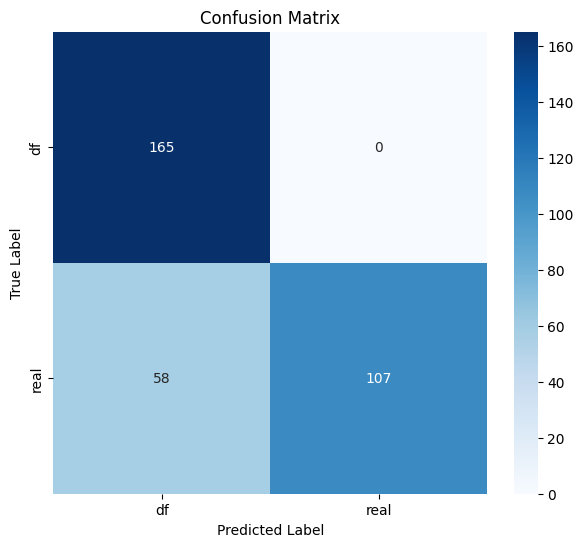

In [12]:
# ==============================================================================
# CELL 6: EVALUATION (Corrected)
# ==============================================================================
print("\n--- Step 6: Evaluating the Model ---")

# FIX: Added 'compute_capsule_length' to the dictionary to prevent an error
custom_objects = {'CapsuleLayer': CapsuleLayer, 'margin_loss': margin_loss, 'squash': squash, 'compute_capsule_length': compute_capsule_length}

# This assumes the 'best_hybrid_model.h5' file is in the same folder as your notebook
best_model = models.load_model('best_hybrid_model.h5', custom_objects=custom_objects)

loss, accuracy = best_model.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")

y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()